In [1]:
import Construct_H_0 as ConstructionSite
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import scipy.optimize as opt
import Fitting_to_Sinus as BobRoss
import os
import importlib
import Plot_BBG
import matplotlib.patches as mpatches
importlib.reload(BobRoss)
importlib.reload(ConstructionSite)
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpat
import matplotlib.cm as cm
import matplotlib
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import sys
matplotlib.rcParams['text.usetex'] = True
import Filling_of_mu_BBG as SexiFermiPlots
importlib.reload(SexiFermiPlots)
importlib.reload(Plot_BBG)
from matplotlib.colors import ListedColormap,to_rgba
import Fitting_to_Sinus as BobRoss

#import h5py

In [2]:
plt.rcParams.update({
"text.usetex": True,
"font.family": "Helvetica"
})    

In [3]:
np.set_printoptions(threshold=sys.maxsize,suppress=True)

def R_x(theta):
    return np.matrix([[ 1, 0           , 0           ],
                   [ 0, np.cos(theta),-np.sin(theta)],
                   [ 0, np.sin(theta), np.cos(theta)]])
  
def R_y(theta):
    return np.matrix([[ np.cos(theta), 0, np.sin(theta)],
                   [ 0           , 1, 0           ],
                   [-np.sin(theta), 0, np.cos(theta)]])
  
def R_z(theta):
    return np.matrix([[ np.cos(theta), -np.sin(theta), 0 ],
                   [ np.sin(theta), np.cos(theta) , 0 ],
                   [ 0           , 0            , 1 ]])

In [8]:
GapVectorArray = np.load("GapVectorArrayBBG_Corrected_U3.npy")

In [6]:
x_frequencies = np.fft.rfftfreq(N_x)
y_frequencies = np.fft.fftfreq(N_y)

Indexlist = []
FrequencyList_Diag = []
for x in range(len(x_frequencies)):
    for y in range(len(y_frequencies)):
        if(np.isclose(x_frequencies[x],y_frequencies[y]) or np.isclose(x_frequencies[x],-y_frequencies[y])):
            Indexlist.append(np.array([x,y]))
            FrequencyList_Diag.append(y_frequencies[y])
Indices = np.array(Indexlist)
FrequencyList_Diag = np.array(FrequencyList_Diag)

x_Diagonals = Indices[:,0]
y_Diagonals = Indices[:,1]

In [7]:
P1 = np.array([-2/np.sqrt(3),2])*np.pi/np.sqrt(3)
P2 = np.array([2/np.sqrt(3),2])*np.pi/np.sqrt(3)
P3 = np.array([4/np.sqrt(3),0])*np.pi/np.sqrt(3)
P4 = np.array([2/np.sqrt(3),-2])*np.pi/np.sqrt(3)
P5 = np.array([-2/np.sqrt(3),-2])*np.pi/np.sqrt(3)
P6 = np.array([-4/np.sqrt(3),0])*np.pi/np.sqrt(3)

M1 = (P1 + P2)/2
M2 = (P2 + P3)/2
M3 = (P3 + P4)/2
M4 = (P4 + P5)/2
M5 = (P5 + P6)/2
M6 = (P6 + P1)/2

MPoints = [M1,M2,M3,M4,M5,M6]
KPoints = [P1,P2,P3,P4,P5,P6]

MPoints = np.array(MPoints)
KPoints = np.array(KPoints)

In [8]:
def mirror(origin, point):

    ox, oy = origin
    px, py = point

    qx = ox - (px - ox)
    qy = oy - (py - oy)
    return qx, qy

In [9]:
def GetGoodIndices(N_x):
    N_tot = N_x*N_x
    Qs,Components = Plot_BBG.Plotit(np.random.random(4*N_tot),returnaxes=True,N_x = N_x,Quickreturn = True)
    Qs = Qs.reshape(2,N_tot)
    Components = (Components.reshape(N_tot,3)).transpose()

    Badindices = []
    for i in range(len(Qs[0,:])):

        if(i in Badindices):
            continue

        Q_Test = -Qs[:,i]
        C1 = np.where((np.isclose(Qs.transpose(),Q_Test))[:,0]*(np.isclose(Qs.transpose(),Q_Test))[:,1])
        if(len(C1[0])==1):

            if(C1[0][0]!= 0):
                Badindices.append(C1[0][0])
        else:

            Q_Test = Qs[:,i]
            C1 = np.where(np.isclose(KPoints,Q_Test)[:,0]*np.isclose(KPoints,Q_Test)[:,1])
            if(len(C1[0])==1):
                continue

            C1 = np.where(np.isclose(MPoints,Q_Test)[:,0]*np.isclose(MPoints,Q_Test)[:,1])
            if(len(C1[0])==1):
                continue

            for M in MPoints:
                Q_Test = mirror(M,Qs[:,i])
                C1 = np.where((np.isclose(Qs.transpose(),Q_Test))[:,0]*(np.isclose(Qs.transpose(),Q_Test))[:,1])
                if(len(C1[0])==1):
                    Badindices.append(C1[0][0])


    Indices = np.array(range(len(Qs[0])))
    GoodIndices = []
    for i in Indices:
        if(i not in Badindices):
            GoodIndices.append(i)
            
    return GoodIndices

GoodIndices = np.array(GetGoodIndices(N_x))

In [10]:
def Plot_Arrows(GapVector,Enhance = 1.5):
    N_ups = GapVector[:N_tot]
    N_downs = GapVector[N_tot:2*N_tot] 
    D_UpDowns = GapVector[2*N_tot:3*N_tot] + 1j*GapVector[3*N_tot:]


    Pol = N_ups-N_downs
    Pol = Pol.reshape(N_y,N_x)
    Filling = N_ups+N_downs
    Filling = Filling.reshape(N_y,N_x)
    
    N_is = N_ups+N_downs
    Phi_is = np.angle(D_UpDowns)
    M_is = np.sqrt((N_ups-N_downs)**2+4*np.abs(D_UpDowns)**2)
    Theta_is = np.arccos((N_ups-N_downs)/M_is)
    M_is = M_is.reshape(N_y,N_x)

    #print(M_is)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
    
    h = np.sqrt(3)/2
    for i in range(N_x):
        for j in range(N_y):
            x_coordinate = i + j*1./2
            y_coordinate = j*h
            Angle = Phi_is[N_x*j+i]-Phi_is[0] +np.pi/2
            dx = Enhance*M_is.flatten()[N_x*j+i]*np.cos(Angle)
            dy = Enhance*M_is.flatten()[N_x*j+i]*np.sin(Angle)
            axes[0].arrow(x_coordinate-dx/2,y_coordinate-dy/2,dx,dy,head_width = 0.12)
    axes[0].set_xlabel("Spin Amplitude and Orientation")
    #axes[0].set_xlim(-1.5,N_x)
    #axes[0].set_ylim(-1,N_y*h)

    #print(Phi_is/np.pi)
    #print((Phi_is[1]-Phi_is[0])/(np.pi),(Phi_is[2]-Phi_is[1])/(np.pi),(Phi_is[3]-Phi_is[2])/(np.pi))
    #print((Phi_is[N_x]-Phi_is[0])%(2*np.pi)/np.pi)
    print("M",np.mean(M_is.flatten()))
    
    im = axes[1].pcolormesh(Filling)
    axes[1].set_xlabel("Filling on each site")
    fig.tight_layout()
    #cax = fig.add_axes([0.99, 0.15, 0.02, 0.8])
    fig.colorbar(im,orientation='vertical')
    
    ###plt.savefig("N_18_20_U4_1over9Doping.pdf",format="pdf")
    plt.show()
    return M_is

In [12]:
def Classification(Gappy,ReturnVecs = False,N_x = N_x,GetIndices = False):

    N_tot = N_x*N_x
    if(GetIndices == True):
        NewGoodIndices = GetGoodIndices(N_x)
    else:
        NewGoodIndices = GoodIndices
    
    Qs,Components= Plot_BBG.Plotit(Gappy,Quickreturn=True,N_x = N_x)

    Qs = Qs.reshape(2,N_tot)
    Components = (Components.reshape(N_tot,3)).transpose()

    Components = Components[:,NewGoodIndices]
    Qs = Qs[:,NewGoodIndices]
    Amplitude = np.linalg.norm(Components,axis = 0)

    ind = np.argpartition(Amplitude, -8)[-8:]
    ind = ind[np.argsort(Amplitude[ind])][::-1]

    TotalNorm = np.linalg.norm(Amplitude)
    CurrentNorm = 0.
    relevantind = []

    for i in ind:
        CurrentNorm = np.sqrt(CurrentNorm**2 + Amplitude[i]**2)
        relevantind.append(i)
        if(CurrentNorm>=0.87*TotalNorm):
            break
    ###Filter k <-> -k raus      
    if(len(relevantind) == 1):
        
        if(ReturnVecs ==True):
            return Components[:,ind[0]]
        
        ind = relevantind[0]

        if(ind == 0):
            return "Ferro"
        
        Q_curr = Qs[:,ind]
        #if(len(np.where((np.isclose(MPoints,Q_curr))[:,0]*(np.isclose(MPoints,Q_curr))[:,1])[0])>0):
        #    return "MMode"
        
        #if(len(np.where((np.isclose(KPoints,Q_curr))[:,0]*(np.isclose(KPoints,Q_curr))[:,1])[0])>0):
        #    return "KMode"
        
        RealVec = np.real(Components[:,ind])
        ImVec = np.imag(Components[:,ind])

        Ratio = (np.abs(RealVec@ImVec)/(np.linalg.norm(RealVec)*np.linalg.norm(ImVec)))
        if(0.9<Ratio<=1.000005):
            return "Stripe"
        
        if(Ratio<0.1):
            print(CurrentNorm/TotalNorm)
            return "Spiral"
        print(Ratio)
        return "Elliptical"

    if(len(relevantind) == 2):
        ##Nähe zu K überprüfen, damit nicht falsch.
        if(ReturnVecs ==True):
            return Components[:,ind[0]],Components[:,ind[1]]
        
        V1 = Components[:,ind[0]]
        V2 = Components[:,ind[1]]
        
        #print(np.abs(V1@V1)/np.linalg.norm(V1)**2)
        #print(np.abs(V2@V2)/np.linalg.norm(V2)**2)
        #print(np.abs(V1@V2.conjugate())/np.linalg.norm(V2)**2)
        #print(np.abs(V1@V2)/np.linalg.norm(V2)**2)      
        
            
        if(np.abs(V1@V1)/np.linalg.norm(V1)**2>0.95 and np.abs(V2@V2)/np.linalg.norm(V2)**2>0.95):
            if(np.abs(V1@V2.conjugate())/np.linalg.norm(V2)**2<0.01 and np.abs(V1@V2)/np.linalg.norm(V2)**2<0.01):
                return "2 orth Stripes"

        if(np.abs(V1@V1)/np.linalg.norm(V1)**2<0.05 and np.abs(V2@V2)/np.linalg.norm(V2)**2<0.05):
            if(np.abs(V1@V2.conjugate())/np.linalg.norm(V2)**2<0.01 and np.abs(V1@V2)/np.linalg.norm(V2)**2>0.95):
                return "2 orth Spirals"            
            
            
        return "Zweierlei"
    
    if(len(relevantind) == 3):
        V1 = Components[:,ind[0]]
        V2 = Components[:,ind[1]]
        V3 = Components[:,ind[2]]
        

            
        if(ReturnVecs==True):
            return V1,V2,V3
        
        if(np.abs(V1.conjugate()@V2)/(np.linalg.norm(V1)*np.linalg.norm(V2))>0.9 and np.abs(V1.conjugate()@V3)/(np.linalg.norm(V1)*np.linalg.norm(V3))>0.9 and np.abs(V3.conjugate()@V2)/(np.linalg.norm(V3)*np.linalg.norm(V2))>0.9):
            return "3ParallelStripes"
        ##Nähe zu K überprüfen, damit nicht falsch.
        if(Amplitude[relevantind[0]]/ Amplitude[relevantind[1]]<1.1 and Amplitude[relevantind[1]]/ Amplitude[relevantind[2]]<1.1):
            
            ind = relevantind
            #print(ind)
            Ratio = np.abs(V1@np.cross(V2,V3))/(np.linalg.norm(V1)*np.linalg.norm(V2)*np.linalg.norm(V3))
            if(ReturnVecs==True):
                return V1,V2,V3
            #print(V1,V2,V3)
            if(Ratio>0.95):
                return "ThreeStripes"
            

            
            #H_x = 1.*V1
            #H_x = np.exp(-1j*np.angle(H_x[0]))*H_x
            
            
            #RotMat = R_y(-np.arccos(np.real(H_x[0])/np.linalg.norm(np.real(H_x))))@R_x(np.arctan(np.real(H_x[1])/np.real(H_x[2]+10**-10)))
            #H_x_test = np.array(RotMat@H_x)[0]
            
            #print(RotMat@V1*np.exp(-1j*np.angle(V1[0])),"V1")
            #print()
            #print(RotMat@V2*np.exp(-1j*np.angle(V2[0])),"V2")
            #print()
            #print(RotMat@V3*np.exp(-1j*np.angle(V3[0])),"V3")
            return "ThreeOfAKind"
        
        return "Dreierlei"
        
    if(len(relevantind) > 3):
        return "Gewusel"

    return "WTF"

    

In [13]:
N_tot = 12*12

In [35]:
ClassArray = np.zeros((len(T_Array),len(t_prime_Array),len(Doping_Array)),dtype = object)

for i in range(len(T_Array)):
    for j in range(4):#range(len(t_prime_Array)):
        print(i)
        for k in range(len(Doping_Array)):
            
            GapVector = GapVectorArray[i,j,k]
            ClassArray[i,j,k] = Classification(GapVector)


0
0.9999999995112688
0.8808995787249383
0.9978841898307023
0.9032635813251179
0.919426292405017
0
0.9999999986843651
0.8246229850457952
0.22113523557025583
0.9986756959784298
0.9059664265120835
0.9259741939759594
0
0.9999999995112688
0.24545846410476738
0.8716846021380192
0.9978841898307024
0.9032635805185597
0.9194262924050459
0
0.9999999986843651
0.8998979957029528
0.9986756959784298
0.9059664256933568
0.9259741939760002
1
0.8808480955312288
0.9977350224578232
0.9042083787057716
1
0.8244810887998799
0.9986255150389555
0.9069084834647453
1
0.9498730373699186
0.8718088662738376
0.997735022457823
0.904208371410793
1
0.8999049318528446
0.9986255150389555
0.9069084760573666
2
0.8825999222527706
0.4042975986638201
2
0.8271116643039882
0.8219059035167111
2
0.8751498247608591
2
3
3
3
3
4
4
4
4
5
5
5
5
6
6
6
6
7
7
0.12009962270343341
7
0.9952688357117908
7
8
8
8
8
9
0.3380533041443916
0.9315344682442465
9
0.3788304263079816
0.5517882021033295
9
0.3191111675639663
0.8024275848103911
9
0.360977

In [34]:
ClassArray_Backup = ClassArray.copy()
BobRoss.Set_Params(N_x,N_y)

In [16]:
def CollinearOrder(GapVector):

    S_x,S_y,S_z = BobRoss.PlotMagn(GapVector,QuickReturn = True)
    if(np.linalg.norm(S_y)/N_tot<0.001 and np.linalg.norm(S_z)/N_tot<0.001):
        return True
    return False

In [17]:
N_tot

144

In [33]:
Norm = np.zeros((len(T_Array),len(t_prime_Array),len(Doping_Array)))

for i in range(len(T_Array)):
    for j in range(len(t_prime_Array)):
        for k in range(len(Doping_Array)):
            GapVector = GapVectorArray[i,j,k]
            N_ups = GapVector[:N_tot]
            N_downs = GapVector[N_tot:2*N_tot]
            D_UpDowns = GapVector[2*N_tot:3*N_tot] + 1j*GapVector[3*N_tot:]
            S_x = 2*np.real(D_UpDowns)
            S_y = 2*np.imag(D_UpDowns)
            S_z = N_ups-N_downs

            Charge_local = GapVectorArray[i,j,k][:N_tot] + GapVectorArray[i,j,k][N_tot:2*N_tot]
            Amplitudes = np.sqrt(S_x**2 + S_y**2 +S_z**2)
            Norm[i,j,k] = 1./N_tot*np.sum(Amplitudes)
            if(Norm[i,j,k]<0.001):
                ClassArray[i,j,k] = "Para"
            if(CollinearOrder(GapVector)==True):
                if(ClassArray[i,j,k]!="Para" and ClassArray[i,j,k]!= "Stripe" and ClassArray[i,j,k] !="Ferro" and ClassArray[i,j,k] !="3ParallelStripes"):
                    ClassArray[i,j,k] = "Collinear"


In [27]:
ColorArrayPlot = np.zeros(ClassArray.shape)
Counter = 0
for i in range(len(T_Array)):
    for j in range(len(t_prime_Array)):
        for k in range(len(Doping_Array)):
            if(ClassArray[i,j,k] == "Ferro"):
                if(k>=20):
                    ColorArrayPlot[i,j,k] = 2.
                else:
                    ColorArrayPlot[i,j,k] = 0

            if(ClassArray[i,j,k] == "Stripe"):
                ColorArrayPlot[i,j,k] = 4.
            if(ClassArray[i,j,k] == "Spiral" or ClassArray[i,j,k] == "ELL"):
                    
                ColorArrayPlot[i,j,k] = 0.    
            if(ClassArray[i,j,k] == "Zweierlei"):
                ColorArrayPlot[i,j,k] = 7
            if(ClassArray[i,j,k] == "Dreierlei"):
                ColorArrayPlot[i,j,k] = 0
            if(ClassArray[i,j,k] == "ThreeOfAKind"):
                ColorArrayPlot[i,j,k] = 6
            if(ClassArray[i,j,k] == "Gewusel"):
                ColorArrayPlot[i,j,k] = 0.
            if(ClassArray[i,j,k] == "WTF"):
                ColorArrayPlot[i,j,k] = 0
            if(ClassArray[i,j,k] == "Para"):
                ColorArrayPlot[i,j,k] = 1.
            if(ClassArray[i,j,k] == "Collinear"):
                
                ColorArrayPlot[i,j,k] = 8.
            if(ClassArray[i,j,k] == "ThreeStripes"):
                ColorArrayPlot[i,j,k] = 5.
            if(ClassArray[i,j,k] == "3ParallelStripes"):
                ColorArrayPlot[i,j,k] = 9.
                
            if(ClassArray[i,j,k] == "2 orth Stripes"):
                ColorArrayPlot[i,j,k] = 3.
                print(i,j,k)

            if(ClassArray[i,j,k] == "2 orth Spirals"):
                ColorArrayPlot[i,j,k] = 0.
                
print(Counter)

0 0 15
0 0 20
0 0 23
0 0 26
0 0 37
0 0 56
0 0 57
0 0 64
0 0 80
0 0 124
0 0 125
0 1 15
0 1 20
0 1 23
0 1 26
0 1 56
0 1 57
0 1 64
0 1 80
0 1 124
0 1 125
0 2 15
0 2 20
0 2 23
0 2 26
0 2 37
0 2 56
0 2 57
0 2 64
0 2 80
0 2 81
0 2 107
0 2 124
0 2 125
0 3 15
0 3 20
0 3 23
0 3 26
0 3 56
0 3 57
0 3 64
0 3 80
0 3 81
0 3 107
0 3 124
0 3 125
1 0 15
1 0 20
1 0 23
1 0 37
1 0 56
1 0 57
1 0 64
1 0 80
1 0 124
1 0 125
1 1 15
1 1 20
1 1 23
1 1 56
1 1 57
1 1 64
1 1 80
1 1 124
1 1 125
1 2 15
1 2 20
1 2 23
1 2 37
1 2 56
1 2 57
1 2 64
1 2 80
1 2 81
1 2 107
1 2 121
1 2 124
1 2 125
1 3 15
1 3 20
1 3 23
1 3 56
1 3 57
1 3 64
1 3 80
1 3 81
1 3 107
1 3 121
1 3 124
1 3 125
2 0 19
2 0 20
2 0 56
2 0 57
2 0 64
2 0 80
2 0 124
2 0 125
2 0 126
2 1 19
2 1 20
2 1 56
2 1 57
2 1 64
2 1 80
2 1 124
2 1 125
2 1 126
2 2 19
2 2 20
2 2 56
2 2 57
2 2 64
2 2 80
2 2 81
2 2 107
2 2 121
2 2 124
2 2 125
2 2 126
2 3 19
2 3 20
2 3 56
2 3 57
2 3 64
2 3 80
2 3 81
2 3 107
2 3 121
2 3 124
2 3 125
2 3 126
3 0 19
3 0 20
3 0 56
3 0 57
3 0 64
3 0

In [28]:
T_Crit_Array = np.load("T_Crit_Array3.npy")

n_Crit_Array = np.load("n_Array3.npy")

ColorOutline = np.load("Color_Array3.npy")

In [29]:
to_rgba("lime")

(0.0, 1.0, 0.0, 1.0)

In [36]:
DF = 0.8
AFMColor = (0.993248, 0.906157, 0.143936, 0.9)
StrangeColor = to_rgba("black")#(0.267004, 0.004874, 0.329415, 1.0)
ParaColor = to_rgba("gainsboro")
StripeColor = (DF*1.,0,0,1)
SpiralColor = (DF*0.369214, DF*0.788888, DF*0.382914, 1.0)
SpiralColor = (0,0.8,0.,0.9)

BColor = to_rgba("orange")
EColor = to_rgba("royalblue")
BeatColor = to_rgba("lightgreen")
BeatColor = to_rgba(StrangeColor)
CollColor = to_rgba("maroon")
CollColor = StrangeColor
ThreeStripeColor = to_rgba("blueviolet")

cmap2 = ListedColormap([StrangeColor,ParaColor,AFMColor,SpiralColor,StripeColor,BColor,EColor,BeatColor,CollColor,ThreeStripeColor])



t_prime =  0.0


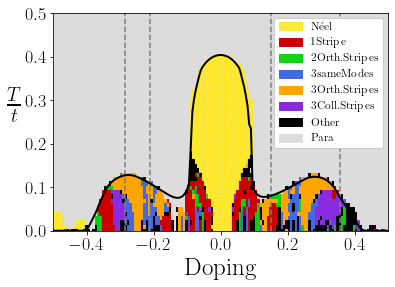

In [83]:
ColorArrayPlot = np.array(ColorArrayPlot,dtype = float)
for i in [0]:
    print("t_prime = ",t_prime_Array[i])

    fig = plt.figure()
    ax = plt.subplot(111)
    X,Y = np.meshgrid(np.array(T_Array),np.array(Doping_Array))
    X = np.array(X,dtype = float).transpose()
    Y = np.array(Y,dtype = float).transpose()
    #ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), fancybox=True, shadow=True)
    cm = ax.pcolormesh(Y,X,ColorArrayPlot[:,i,:],vmin=0, vmax=9,shading ="nearest",cmap = cmap2)
    ax.set_xlabel(r"Doping",fontsize = 25)
    ax.set_ylabel(r"$\frac{T}{t}$",fontsize = 28,rotation="horizontal",ha = "right")
    
    ax.vlines(1.-0.849,0.,0.5, color = "grey",linestyle = "dashed")
    ax.vlines(1.-0.6442,0.,0.5, color = "grey",linestyle = "dashed")
    ax.vlines(1.-1.2116,0.,0.5, color = "grey",linestyle = "dashed")
    ax.vlines(1.-1.2864,0.,0.5, color = "grey",linestyle = "dashed")

    values = [2,4,3,6,5,9,0,1]
    colors = [ cm.cmap(cm.norm(value)) for value in values]
    labelArray = [r"N\'eel",r"1Stripe",r"2Orth.Stripes",r"3sameModes",r"3Orth.Stripes","3Coll.Stripes",r"Other",r"Para"]
    patches = [mpatches.Patch(color=colors[i], label=labelArray[i] ) for i in range(len(values)) ]
    legend = ax.legend(handles=patches, bbox_to_anchor=(0.66, 0.98), loc=2, borderaxespad=0.,fontsize = 11.4 )
    legend.get_frame().set_alpha(1.)

    ax.plot(1-n_Crit_Array,T_Crit_Array,"black",linewidth = 2)
    ax.set_xlim(-0.5,0.5)
    ax.set_ylim(0,0.5)
    plt.yticks(fontsize=18)
    plt.xticks(fontsize=18)
    ###plt.savefig("PhaseDiagram_BBG_2ModesIsStrange_SpiralStrange_2OrthStripes_vanHove_New_CorrectUnits_BigTicks_1Stripe.png",bbox_inches='tight',dpi = 800)
    plt.show()


t_prime =  1.0


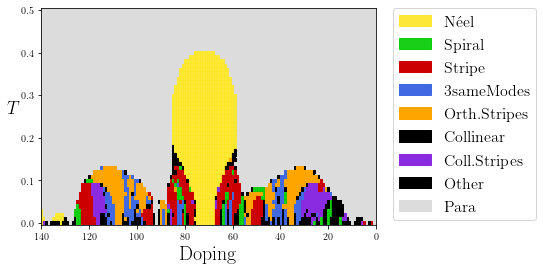

In [38]:
ColorArrayPlot = np.array(ColorArrayPlot,dtype = float)
for i in [1]:#range(4):
    print("t_prime = ",t_prime_Array[i])

    fig = plt.figure()
    ax = plt.subplot(111)
    X,Y = np.meshgrid(np.array(T_Array),np.linspace(0,143,144))
    X = np.array(X,dtype = float).transpose()
    Y = np.array(Y,dtype = float).transpose()
    #ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), fancybox=True, shadow=True)
    cm = ax.pcolormesh(Y,X,ColorArrayPlot[:,i,:],vmin=0, vmax=9,shading ="nearest",cmap = cmap2)
    ax.set_xlabel(r"Doping",fontsize = 20)
    ax.set_ylabel(r"$T$",fontsize = 18,rotation="horizontal",ha = "right")
    
    
    values = [2,3,4,6,5,8,9,0,1]
    colors = [ cm.cmap(cm.norm(value)) for value in values]
    labelArray = [r"N\'eel",r"Spiral",r"Stripe",r"3sameModes",r"Orth.Stripes",r"Collinear","Coll.Stripes",r"Other",r"Para"]
    patches = [mpatches.Patch(color=colors[i], label=labelArray[i] ) for i in range(len(values)) ]
    ax.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize = 16 )
    ax.set_xlim(140,0)
    #ax.set_ylim(0,0.5)
    ##plt.savefig("PhaseDiagram_BBG_2ModesIsStrange.png",bbox_inches='tight',dpi = 300)
    plt.show()

In [39]:
i,j = 4,1

for k in range(0,144):

    Gappy1 = GapVectorArray[i,j,k]
    N_x_New = 24
    
    T = T_Array[i]
    Doping = Doping_Array[k]
    n_filling = 1-Doping
    Gappy2 = np.load("../../../Cluster/BernalBilayerGraphene/BBG_BigLattice/GapVectors/GapVector_Nx{}_Ny{}_U{}_Filling{:.8}_Temperature{:.6}:.6_DispField{:.6}_mitt4.npy".format(N_x_New,N_x_New,3.,n_filling,T,0.))

    if(k == 124):
        Gappy_Analysis = Gappy2
    
    Gappy2 = Gappy2[::4]

    print(k)
    print(Classification(Gappy1,N_x=N_x))

    print(Classification(Gappy2,N_x=N_x_New,GetIndices = True))
    print()
    #_=Plot_BBG.Plotit(Gappy1,returnaxes=True,N_x = N_x)
    #_=Plot_BBG.Plotit(Gappy2,returnaxes=True,N_x = N_x_New)
    
    

0
Gewusel
Gewusel

1
Gewusel
Gewusel

2
Stripe
Gewusel

3
Zweierlei
Gewusel

4
Zweierlei
Gewusel

5
Dreierlei
Gewusel

6
Gewusel
Gewusel

7
Gewusel
Gewusel

8
Gewusel
Gewusel

9
Gewusel
Gewusel

10
Gewusel
Gewusel

11
Gewusel
Gewusel

12
Gewusel
Gewusel

13
Ferro
Gewusel

14
Ferro
Zweierlei

15
Ferro
Zweierlei

16
Ferro
Dreierlei

17
Ferro
ThreeStripes

18
Ferro
ThreeStripes

19
2 orth Stripes
ThreeStripes

20
Zweierlei
2 orth Stripes

21
Dreierlei
ThreeStripes

22
3ParallelStripes
ThreeStripes

23
3ParallelStripes
2 orth Stripes

24
3ParallelStripes
2 orth Stripes

25
3ParallelStripes
Gewusel

26
3ParallelStripes
Gewusel

27
3ParallelStripes
Zweierlei

28
3ParallelStripes
3ParallelStripes

29
3ParallelStripes
3ParallelStripes

30
3ParallelStripes
Dreierlei

31
3ParallelStripes
ThreeOfAKind

32
ThreeOfAKind
ThreeOfAKind

33
ThreeOfAKind
ThreeOfAKind

34


KeyboardInterrupt: 

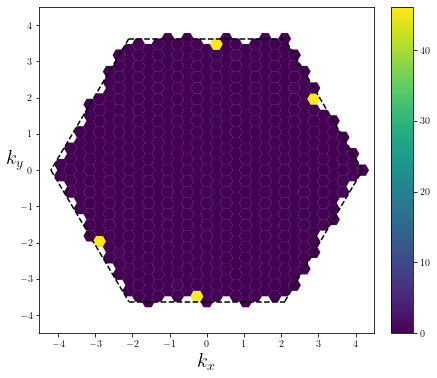

In [745]:
for k in [120]:

    Gappy1 = GapVectorArray[i,j,k]
    N_x_New = 24
    T = T_Array[i]
    Doping = Doping_Array[k]
    n_filling = 1-Doping
    Gappy2 = np.load("../../../Cluster/BernalBilayerGraphene/BBG_BigLattice/GapVectors/GapVector_Nx{}_Ny{}_U{}_Filling{:.8}_Temperature{:.6}:.6_DispField{:.6}_mitt4.npy".format(N_x_New,N_x_New,3.,n_filling,T,0.))


    Gappy2 = Gappy2[::4]
    if(Classification(Gappy2,N_x=N_x_New,GetIndices = True) == "Zweierlei"):
        print(k)
        V1,V2 = Classification(Gappy2,N_x=N_x_New,GetIndices = True,ReturnVecs = True)
        #V1,V2 = Classification(Gappy1,N_x=N_x,GetIndices = True,ReturnVecs = True)
        print(np.abs(V1@V1)/np.linalg.norm(V1)**2)
        print(np.abs(V2@V2)/np.linalg.norm(V2)**2)
        print(np.abs(V1@V2.conjugate())/np.linalg.norm(V2)**2)
        print(np.abs(V1@V2)/np.linalg.norm(V2)**2)
    #print(k)
    #print(Classification(Gappy1,N_x=N_x))

    #print(Classification(Gappy2,N_x=N_x_New,GetIndices = True))
    #print()
    ##_=Plot_BBG.Plotit(Gappy1,returnaxes=True,N_x = N_x)
    _=Plot_BBG.Plotit(Gappy2,returnaxes=True,N_x = N_x_New)

In [40]:
V1*np.exp(1j*-1*np.angle(V1[0]))

array([5.+0.j, 0.+5.j, 0.+0.j])

0.0 -0.36111111111110805
2 orth Stripes
0.9999891051149467
0.9999891051149461
0.0050612415890249965
0.00195614800404363


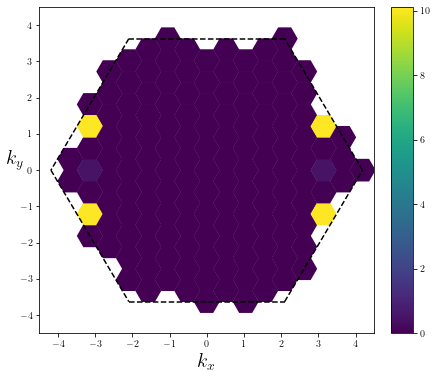

In [41]:
i,j,k = 0,0,124
print(T_Array[i],Doping_Array[k])
Gappy = GapVectorArray[i,j,k]
print(ClassArray[i,j,k])
#print(Classification(Gappy))
#print(ColorArrayPlot[i,j,k],"CAP")
V1,V2 = Classification(Gappy,ReturnVecs=True)


#S1,S2,S3 = np.linalg.norm(V1),np.linalg.norm(V2),np.linalg.norm(V3)
#print("NORMS",np.linalg.norm(V1),np.linalg.norm(V2))

#print(np.abs(V1@V3)/(S1*S2))
#print(np.abs(V1@V2)/(S1*S2))
print(np.abs(V1@V1)/np.linalg.norm(V1)**2)
print(np.abs(V2@V2)/np.linalg.norm(V2)**2)
print(np.abs(V1@V2.conjugate())/np.linalg.norm(V2)**2)
print(np.abs(V1@V2)/np.linalg.norm(V2)**2)    

Qs,Components,fig,ax = Plot_BBG.Plotit(Gappy,returnaxes=True,N_x = N_x)

In [42]:
i,j,k = 0,1,124
Gappy = GapVectorArray[i,j,k]
V3,V4 = Classification(Gappy,ReturnVecs=True)

i,j,k = 0,0,124
Gappy = GapVectorArray[i,j,k]
V1,V2 = Classification(Gappy,ReturnVecs=True)

In [43]:
V1 = V1*np.exp(-1j*np.angle(V2[0]))
V2 = V2*np.exp(-1j*np.angle(V2[0]))
V3 = V3*np.exp(-1j*np.angle(V2[0]))
V4 = V4*np.exp(-1j*np.angle(V2[0]))


In [44]:
RotMat = R_y(np.arccos(np.real(V2[0])/np.linalg.norm(np.real(V2))))@R_x(np.arctan(np.real(V2[1])/np.real(V2[2]+10**-10)))

V1 = np.array(RotMat@V1)[0]
V2 = np.array(RotMat@V2)[0]
V3 = np.array(RotMat@V3)[0]
V4 = np.array(RotMat@V4)[0]

RotMat = R_x(np.arccos(np.imag(V1[2])/np.linalg.norm(np.imag(V1))))
#RotMat = R_y(0)

V1 = np.array(RotMat@V1)[0]
V2 = np.array(RotMat@V2)[0]
V3 = np.array(RotMat@V3)[0]
V4 = np.array(RotMat@V4)[0]

In [45]:
10*np.exp((-1.4 - 0.5*np.pi)*1j)

(-9.854497299884601-1.6996714290024109j)

In [46]:
print(V1)
print(V2)
print(V3)
print(V4)

[ 0.02358434 -0.01984733j -0.00000001 -0.00000513j
  0.01352024+10.11607162j]
[10.11609341+0.01160736j  0.        -0.00000001j  0.        +0.02361081j]
[-0.00944019-0.03424977j -0.00000091-0.00000494j  1.78651497+9.73224726j]
[-9.73229572-1.78653005j -0.00000001-0.j          0.01515966+0.00593587j]


In [47]:
V1 = GapVectorArray[0,1,124]
V2 = GapVectorArray[0,0,124]
np.save("../../../Bilayer Graphene/2OrthStripesVector1.npy",V1)
np.save("../../../Bilayer Graphene/2OrthStripesVector2.npy",V2)

In [48]:
VectorArray = np.zeros((len(T_Array),len(t_prime_Array),len(Doping_Array)))
Norm = np.zeros((len(T_Array),len(t_prime_Array),len(Doping_Array)))
Norm2 = np.zeros((len(T_Array),len(t_prime_Array),len(Doping_Array)))

N_tot = N_x*N_y

for i in range(len(T_Array)):
    for j in range(len(t_prime_Array)):
        for k in range(len(Doping_Array)):

            Charge = 1-Doping_Array[k]
            
            
            GapVector = GapVectorArray[i,j,k]
            N_ups = GapVector[:N_tot]
            N_downs = GapVector[N_tot:2*N_tot]
            D_UpDowns = GapVector[2*N_tot:3*N_tot] + 1j*GapVector[3*N_tot:]
            S_x = (2*np.real(D_UpDowns))
            S_y = (2*np.imag(D_UpDowns))
            S_z = (N_ups-N_downs)

            Charge_local = GapVectorArray[i,j,k][:N_tot] + GapVectorArray[i,j,k][N_tot:2*N_tot]
            Amplitudes = np.sqrt(S_x**2 + S_y**2 +S_z**2)/2
            Norm[i,j,k] = 1./N_tot*np.sum(Amplitudes)
            Norm2[i,j,k] = 1./N_tot*(np.sum(Amplitudes[0::4] + Amplitudes[1::4]-Amplitudes[2::4]-Amplitudes[3::4]))


In [49]:
T_Crit_Array = np.load("../../../Gauge Theory/TriangularLattice/Penis_T_Crit_Array3.npy")

n_Array = np.load("../../../Gauge Theory/TriangularLattice/Penis_n_Array3.npy")

t_prime =  0.0


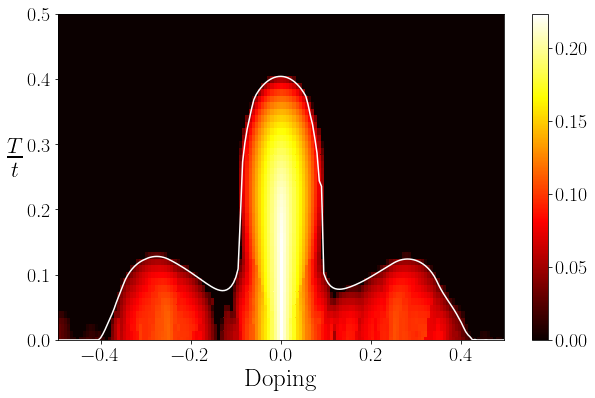

In [52]:
for i in range(1):
    print("t_prime = ",t_prime_Array[i])

    fig = plt.figure(figsize = (10,6))
    ax = plt.subplot(111)
    X,Y = np.meshgrid(np.array(T_Array),np.array(Doping_Array))
    X = np.array(X,dtype = float).transpose()
    Y = np.array(Y,dtype = float).transpose()
    #ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), fancybox=True, shadow=True)
    Data = 1./4*(Norm[:,0,:] + Norm[:,1,:] + Norm[:,2,:] + Norm[:,3,:])
    cm = ax.pcolormesh(Y,X,Data,shading = "nearest",cmap = "hot",vmin=min(0,np.min((Data))), vmax=np.max(abs(Data)))
    #ax.plot(Doping_Array,Stable_Spiral_Border[:,i],"white",linestyle = "--")
    #ax.plot(Doping_Array,Unstable_Spiral_Border[:,i],"white",linestyle = "dotted")
    #ax.plot(Doping_Array,Neel_Border[:,i],"white") 
    ax.set_xlabel(r"Doping",fontsize = 25)
    ax.set_ylabel(r"$\frac{T}{t}$",fontsize = 32,rotation="horizontal",ha = "right")
    #ax.set_ylim(-0.005,0.245)
    cb = fig.colorbar(cm)
    ###plt.savefig("PhaseDiagram_BernalBilayerGraphene_Temperature_Doping_DefinatelyDoesntLookLikeAPenis.png",dpi = 400)
    #ax.plot(1-n_Array,T_Crit_Array,"white")
    ax.plot(1-n_Array,T_Crit_Array,"white",linewidth = 1.5)
    
    #ax.plot(1-n_Array2,T_Crit_Array2,"black",linestyle = "dashed")
    ax.set_ylim(0.,0.5)
    ax.set_xlim(-0.495,0.495)
    #ax.vlines(1-0.849,0,0.5,"white",linestyle = "dashed")
    #ax.vlines(1-0.6442,0,0.5,"white",linestyle = "dashed")
    #ax.vlines(1-1.2116,0,0.5,"white",linestyle = "dashed")
    #ax.vlines(1-1.2864,0,0.5,"white",linestyle = "dashed")
    
    plt.yticks(fontsize=20)
    plt.xticks(fontsize=20)
    
    #ax.vlines(1.-0.8490,0.,0.5, color = "whitesmoke",linestyle = "dashed")
    #ax.vlines(1.-0.6442,0.,0.5, color = "whitesmoke",linestyle = "dashed")
    #ax.vlines(1.-1.2116,0.,0.5, color = "whitesmoke",linestyle = "dashed")
    #ax.vlines(1.-1.2864,0.,0.5, color = "whitesmoke",linestyle = "dashed")
    
    cb.ax.tick_params(labelsize=20)
    
    ##plt.savefig("SpinAmplitudes_BBG_CorrectUnits.png",bbox_inches = "tight", dpi = 400)
    
    plt.show()

In [54]:
#########np.save("GapVectorArrayBBG_Corrected_U3_LongConvergence.npy",GapVectorArray)

In [299]:
def Plot_Arrows(GapVector,ShowSpin = True,ShowCharge = True,Scale = 0.5,SetMin = False,SetMax = False,Zoom = 1.):
    N_ups = GapVector[:N_tot]
    N_downs = GapVector[N_tot:2*N_tot] 
    D_UpDowns = GapVector[2*N_tot:3*N_tot] + 1j*GapVector[3*N_tot:]


    


    
    if(ShowCharge == True):
        Filling = N_ups+N_downs
    
        if(SetMin == False):
            Minimum = min(Filling.flatten())
        else:
            Minimum = SetMin
        
        if(SetMax == False):
            Maximum = max(Filling.flatten())
        else:
            Maximum = SetMax
            
        Diff = Maximum - Minimum


        RelFil0 = (Filling[0::4].reshape(N_y,N_x)- Minimum)/Diff
        RelFil1 = (Filling[1::4].reshape(N_y,N_x)- Minimum)/Diff
        RelFil2 = (Filling[2::4].reshape(N_y,N_x)- Minimum)/Diff
        RelFil3 = (Filling[3::4].reshape(N_y,N_x)- Minimum)/Diff
        
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

        Modulus = (N_x)*np.sqrt(3)  
        cmap = matplotlib.cm.get_cmap('plasma')




        for i in range(N_x):
            for j in range(N_y):

                xcoord = i*np.sqrt(3) + j*np.sqrt(3)/2 
                ycoord = 1.5*j

                color0 = cmap(RelFil0[i,j])
                color1 = cmap(RelFil1[i,j])
                color2 = cmap(RelFil2[i,j])
                color3 = cmap(RelFil3[i,j])

                axes[0].add_patch(mpat.Circle(((xcoord+ 0.001)%Modulus - 0.001,ycoord),0.2,facecolor = color0))
                axes[0].add_patch(mpat.Circle(((xcoord + np.sqrt(3)/2 + 0.001)%Modulus - 0.001,ycoord + 1./2),0.2,facecolor = color1))
                axes[1].add_patch(mpat.Circle(((xcoord+ 0.001)%Modulus - 0.001,ycoord),0.2,facecolor = color2))
                axes[1].add_patch(mpat.Circle(((xcoord + np.sqrt(3)/2 + 0.001)%Modulus - 0.001,ycoord - 1./2),0.2,facecolor = color3))

        axes[0].set_xlim(-1,(N_x-1)*np.sqrt(3) + np.sqrt(3)/2 + 1)
        axes[0].set_ylim(-1,N_y*1.5-0.5 )
        
        axes[1].set_xlim(-1,(N_x-1)*np.sqrt(3) + np.sqrt(3)/2 + 1)
        axes[1].set_ylim(-1,N_y*1.5-0.5 )
        
        axes[0].set_xlabel("Lower Layer",fontsize = 16)
        axes[1].set_xlabel("Upper Layer",fontsize = 16)
        
        
        newcax = inset_axes(axes[1],
                    width="7%",  # width = 50% of parent_bbox width
                    height="100%",  # height : 5%
                    bbox_to_anchor=(0.14, 0., 1, 1),
                    bbox_transform=axes[1].transAxes,
                    borderpad=0)
        
        plt.colorbar(matplotlib.cm.ScalarMappable(norm = matplotlib.colors.Normalize(Minimum,Maximum),cmap=cmap),cax = newcax)
        
        if(ShowSpin == False):
            plt.show()
        
    if(ShowSpin == True):
        
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

        Modulus = (N_x)*np.sqrt(3)  

        Phi_is = np.angle(D_UpDowns)
        M_is = np.sqrt((N_ups-N_downs)**2+4*np.abs(D_UpDowns)**2)

        Phi_is1 = Phi_is[0::4]
        Phi_is2 = Phi_is[1::4]
        Phi_is3 = Phi_is[2::4]
        Phi_is4 = Phi_is[3::4]

        M_is1 = M_is[0::4]
        M_is2 = M_is[1::4]
        M_is3 = M_is[2::4]
        M_is4 = M_is[3::4]
        
        for i in range(N_x):
            for j in range(N_y):

                xcoord = i*np.sqrt(3) + j*np.sqrt(3)/2 
                ycoord = 1.5*j
                
                
                x1,y1 = (xcoord+ 0.001)%Modulus - 0.001, ycoord
                x2,y2 = (xcoord + np.sqrt(3)/2 + 0.001)%Modulus - 0.001, ycoord + 1./2
                x3,y3 = (xcoord+ 0.001)%Modulus - 0.001,ycoord
                x4,y4 = (xcoord + np.sqrt(3)/2 + 0.001)%Modulus - 0.001,ycoord - 1./2
                
                Angle1 = Phi_is1[N_x*j+i]-Phi_is1[0] +np.pi/2
                dx1 = 2*M_is1[N_x*j+i]*np.cos(Angle1)*Scale
                dy1 = 2*M_is1[N_x*j+i]*np.sin(Angle1)*Scale
                
                Angle2 = Phi_is2[N_x*j+i]-Phi_is1[0] +np.pi/2
                dx2 = 2*M_is2[N_x*j+i]*np.cos(Angle2)*Scale
                dy2 = 2*M_is2[N_x*j+i]*np.sin(Angle2)*Scale
                
                Angle3 = Phi_is3[N_x*j+i]-Phi_is1[0] +np.pi/2
                dx3 = 2*M_is3[N_x*j+i]*np.cos(Angle3)*Scale
                dy3 = 2*M_is3[N_x*j+i]*np.sin(Angle3)*Scale
                
                Angle4 = Phi_is4[N_x*j+i]-Phi_is1[0] +np.pi/2
                dx4 = 2*M_is4[N_x*j+i]*np.cos(Angle4)*Scale
                dy4 = 2*M_is4[N_x*j+i]*np.sin(Angle4)*Scale

                axes[0].arrow(x1-dx1/2,y1-dy1/2,dx1,dy1,head_width = 0.12)
                axes[0].arrow(x2-dx2/2,y2-dy2/2,dx2,dy2,head_width = 0.12)
                axes[1].arrow(x3-dx3/2,y3-dy3/2,dx3,dy3,head_width = 0.12)
                axes[1].arrow(x4-dx4/2,y4-dy4/2,dx4,dy4,head_width = 0.12)

        axes[0].set_xlim(-1,((N_x-1)*np.sqrt(3) + np.sqrt(3)/2 + 1)/Zoom)
        axes[0].set_ylim(-1,(N_y*1.5-0.5 )/Zoom)

        axes[1].set_xlim(-1,((N_x-1)*np.sqrt(3) + np.sqrt(3)/2 + 1)/Zoom)
        axes[1].set_ylim(-1,(N_y*1.5-0.5 )/Zoom)
        axes[0].set_xlabel("Lower Layer",fontsize = 16)
        axes[1].set_xlabel("Upper Layer",fontsize = 16)        
        
        
        plt.show()
        
    return M_is


In [316]:
N_tot = 4*N_x*N_x

T =  0.03 Doping =  0.4583333333333335


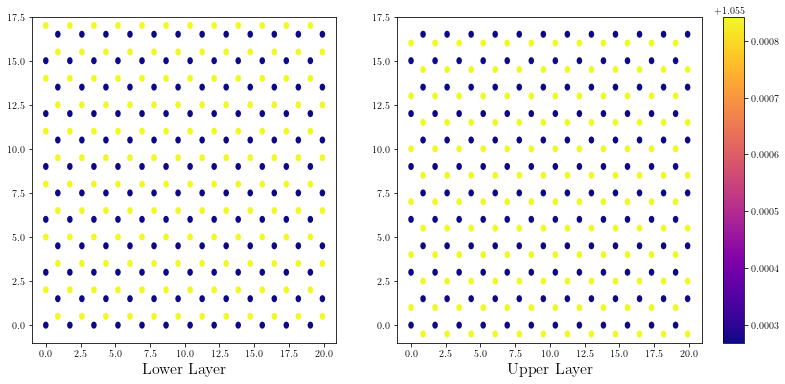

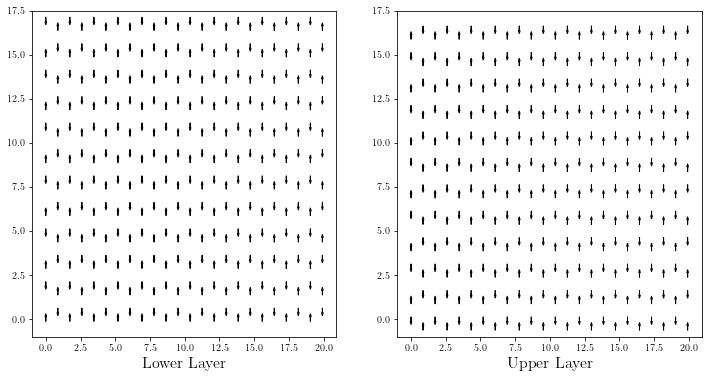

In [323]:
i,k = 3,6
#SexiFermiPlots.Plot_Fermi_Surface(T_Array[i],Doping_Array[k])
M_s = Plot_Arrows(Full_Arrays[15,80],Zoom =1)

In [153]:
A = np.linspace(0,143,144,dtype = int)
for f in A:
    print("{}".format(f), end=' ')

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 

In [36]:
FullArrays

NameError: name 'FullArrays' is not defined

0.0 -0.24999999999999734
ThreeStripes
ThreeStripes


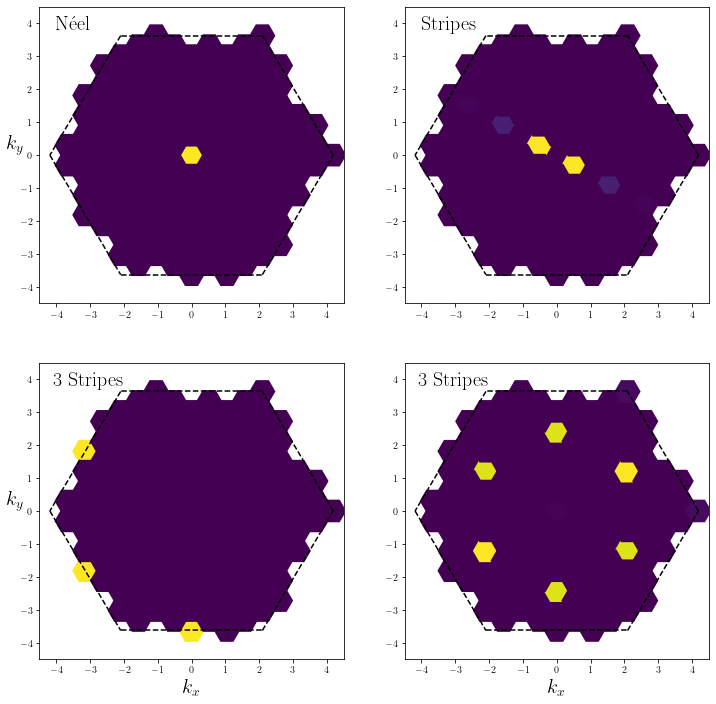

In [300]:
P1 = np.array([-2/np.sqrt(3),2])*np.pi/np.sqrt(3)
P2 = np.array([2/np.sqrt(3),2])*np.pi/np.sqrt(3)
P3 = np.array([4/np.sqrt(3),0])*np.pi/np.sqrt(3)
P4 = np.array([2/np.sqrt(3),-2])*np.pi/np.sqrt(3)
P5 = np.array([-2/np.sqrt(3),-2])*np.pi/np.sqrt(3)
P6 = np.array([-4/np.sqrt(3),0])*np.pi/np.sqrt(3)

Points = np.array([P1,P2,P3,P4,P5,P6])
    
i,j,k = 0,0,108
print(T_Array[i],Doping_Array[k])
Gappy = GapVectorArray[i,j,k]
print(ClassArray[i,j,k])
print(Classification(Gappy))

VecArrayNew1,Components1 = Plot_BBG.Plotit(GapVectorArray[0,0,72],returnaxes=False,N_x = N_x,Quickreturn = True)
VecArrayNew2,Components2 = Plot_BBG.Plotit(GapVectorArray[6,0,66],returnaxes=False,N_x = N_x,Quickreturn = True)
VecArrayNew3,Components3 = Plot_BBG.Plotit(GapVectorArray[0,0,108],returnaxes=False,N_x = N_x,Quickreturn = True)
VecArrayNew4,Components4 = Plot_BBG.Plotit(GapVectorArray[7,0,-41],returnaxes=False,N_x = N_x,Quickreturn = True)



fig,axes = plt.subplots(nrows=2, ncols=2,figsize = (12,12))

im1 = axes[0,0].scatter(VecArrayNew1[0,:,:],VecArrayNew1[1,:,:],c = np.linalg.norm(Components1,axis = 2),marker = "H",s=8200*(np.sqrt(3)*2/N_x)**2,linewidth = 0,)  
im2 = axes[0,1].scatter(VecArrayNew2[0,:,:],VecArrayNew2[1,:,:],c = np.linalg.norm(Components2,axis = 2),marker = "H",s=8200*(np.sqrt(3)*2/N_x)**2,linewidth = 0,)  
im3 = axes[1,0].scatter(VecArrayNew3[0,:,:],VecArrayNew3[1,:,:],c = np.linalg.norm(Components3,axis = 2),marker = "H",s=8200*(np.sqrt(3)*2/N_x)**2,linewidth = 0,)  
im3 = axes[1,1].scatter(VecArrayNew4[0,:,:],VecArrayNew4[1,:,:],c = np.linalg.norm(Components4,axis = 2),marker = "H",s=8200*(np.sqrt(3)*2/N_x)**2,linewidth = 0,)  

#cax = fig.add_axes([0.94, 0.125, 0.05, 0.755])

#fig.colorbar(im, cax=cax, orientation='vertical')

for i in range(6):
    for ol in range(2):
        axes[0][ol].plot([Points[i][0],Points[i-1][0]],[Points[i][1],Points[i-1][1]],"black",linestyle = "dashed")
        axes[0][ol].set_xlim(-4.5,4.5)
        axes[0][ol].set_ylim(-4.5,4.5)

axes[0][0].set_ylabel(r"$k_y$",fontsize = 20,rotation = "horizontal")

for i in range(6):
    for ol in range(2):
        axes[1][ol].plot([Points[i][0],Points[i-1][0]],[Points[i][1],Points[i-1][1]],"black",linestyle = "dashed")
        axes[1][ol].set_xlim(-4.5,4.5)
        axes[1][ol].set_ylim(-4.5,4.5)
        
axes[1][0].set_ylabel(r"$k_y$",fontsize = 20,rotation = "horizontal")     
        
axes[1,0].set_xlabel(r"$k_x$",fontsize = 20)
axes[1,1].set_xlabel(r"$k_x$",fontsize = 20)


axes[0,0].text(-4,3.8,r"Néel",fontsize = 20)
axes[0,1].text(-4,3.8,r"Stripes",fontsize = 20)
axes[1,0].text(-4.1,3.8,r"3 Stripes",fontsize = 20)
axes[1,1].text(-4.1,3.8,r"3 Stripes",fontsize = 20)

###plt.savefig("3FourierPatterns.png",bbox_inches = "tight")
plt.show()